In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv('/content/sample_data/07_train.csv')

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# split target and features
X_train = train_set.drop('Premium Amount', axis=1)
y_train = train_set['Premium Amount'].copy()
X_test = test_set.drop('Premium Amount', axis=1)
y_test = test_set['Premium Amount'].copy()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

## Momentum

In [50]:
# cyclic momentum
class CyclicMomentumScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, start_lr=1e-4, max_lr=1e-3, start_mom=0.9, min_mom=0.7, cyclic_mom=False, cyclic_lr=False):
        self.iterations = iterations
        self.start_lr = start_lr
        self.max_lr = max_lr
        self.start_mom = start_mom
        self.min_mom = min_mom
        self.iteration = 0
        self.lr = []
        self.cyclic_mom = cyclic_mom
        self.cyclic_lr = cyclic_lr
        self.current_lr = start_lr

    def _interpolate(self, iter1, iter2, lr1, lr2):
        slope = (lr2 - lr1) / (iter2 - iter1)
        delta = self.iteration - iter1
        return delta * slope + lr1

    def on_batch_begin(self, batch, logs=None):
        # learning rate
        if self.cyclic_lr:
            lr = self._interpolate(0, self.iterations, self.start_lr, self.max_lr)
            self.current_lr = lr
            lr = float(lr)
            self.model.optimizer.learning_rate.assign(lr)

        # momentum
        if self.cyclic_mom:
            mom = self._interpolate(0, self.iterations, self.min_mom, self.start_mom)
            mom = float(mom)
            self.model.optimizer.momentum = mom

        self.iteration += 1

    # add learning rate to history
    def on_epoch_begin(self, epoch, logs):
        print(self.current_lr)
        print(self.model.optimizer.momentum)
        self.lr.append(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)))

### Constant Momentum
- model 1: 0.9
- model 2: 0.7
- model 3: 0.99

Cyclic Learning Rate: 0.0002-0.002

WD: 1e-6

In [42]:
# model 1: 0.9
import math

model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0002, weight_decay=1e-6, momentum=0.9),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=False, cyclic_lr=True, start_lr=2e-4, max_lr=2e-3)]

history1 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


0.0002
0.9
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 2.1709 - val_loss: 1.1030
0.00028998800000000003
0.9
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.0998 - val_loss: 1.1068
0.00037998800000000005
0.9
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0962 - val_loss: 1.0986
0.00046998799999999996
0.9
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0984 - val_loss: 1.0977
0.000559988
0.9
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0953 - val_loss: 1.1081
0.000649988
0.9
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 1.0933 - val_loss: 1.3033
0.000739988
0.9
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0891 - val_loss: 1.9270
0.0008299879999999999
0.9
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0854 - val_loss: 1.1826
0.000919988
0.9
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.0871 - val_loss: 1.1024
0.001009988
0.9
E

In [43]:
# model 2: 0.7
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, weight_decay=1e-6, momentum=0.7),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=False, cyclic_lr=True, start_lr=2e-4, max_lr=2e-3)]

history2 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.0002
0.7
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 3.5354 - val_loss: 1.1084
0.00028998800000000003
0.7
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 1.1046 - val_loss: 1.1000
0.00037998800000000005
0.7
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.0983 - val_loss: 1.0993
0.00046998799999999996
0.7
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1.0973 - val_loss: 1.1037
0.000559988
0.7
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 1.0976 - val_loss: 1.0972
0.000649988
0.7
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.0958 - val_loss: 1.0988
0.000739988
0.7
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.0962 - val_loss: 1.0964
0.0008299879999999999
0.7
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.0937 - val_loss: 1.1096
0.000919988
0.7
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 1.0909 - val_loss: 1.0939
0.001009988
0.7
E

In [45]:
# model 3: 0.99
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, weight_decay=1e-6, momentum=0.99),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=False, cyclic_lr=True, start_lr=2e-4, max_lr=2e-3)]

history3 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.0002
0.99
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 1.5735 - val_loss: 1.0994
0.00028998800000000003
0.99
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1.0992 - val_loss: 1.3049
0.00037998800000000005
0.99
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 1.0899 - val_loss: 1.7311
0.00046998799999999996
0.99
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.0888 - val_loss: 1.4407
0.000559988
0.99
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1.0883 - val_loss: 1.0982
0.000649988
0.99
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 1.0877 - val_loss: 1.1605
0.000739988
0.99
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.0879 - val_loss: 1.0915
0.0008299879999999999
0.99
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0876 - val_loss: 1.2625
0.000919988
0.99
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0870 - val_loss: 1.4877
0.001009

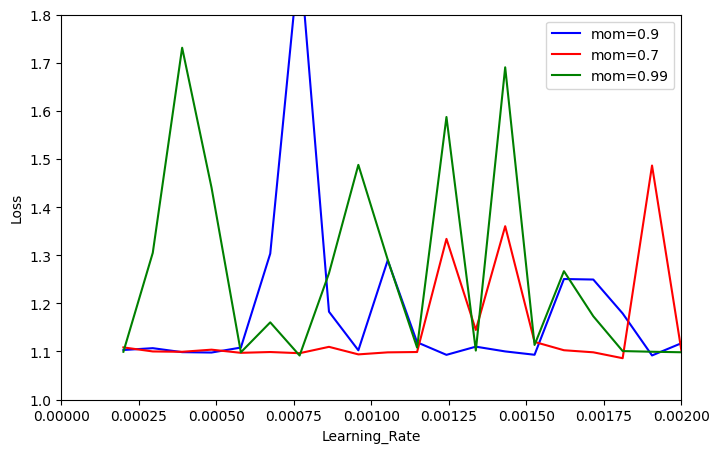

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
l_rates = np.linspace(2e-4, 2e-3, 20)

plt.plot(l_rates, history1.history['val_loss'], 'b-', label='mom=0.9')
plt.plot(l_rates, history2.history['val_loss'], 'r-', label='mom=0.7')
plt.plot(l_rates, history3.history['val_loss'], 'g-', label='mom=0.99')

plt.xlabel('Learning_Rate')
plt.ylabel('Loss')
plt.xlim([0, 2e-3])
plt.ylim([1, 1.8])
plt.legend()
plt.show()

### Increasing Momentum
- model 1: 0.7-1

Learning Rate: 0.001

WD: 1e-6

In [51]:
# model 1: 0.7-1
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, weight_decay=1e-6, momentum=1.0),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=True, cyclic_lr=False, start_mom=0.7, min_mom=1.0)]

history4 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.0001
1.0
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 3.2452 - val_loss: 4.8325
0.0001
0.985002
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 3.8363 - val_loss: 82.4324
0.0001
0.970002
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 67.5419 - val_loss: 14314.9346
0.0001
0.955002
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 618.5381 - val_loss: 2364.3418
0.0001
0.940002
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2420.1421 - val_loss: 9170.4209
0.0001
0.925002
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 145402.3594 - val_loss: 1140735.3750
0.0001
0.910002
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 929660.1875 - val_loss: 543821.5625
0.0001
0.895002
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4225893.0000 - val_loss: 6917746.0000
0.0001
0.880002
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 8102304.0000 - val_loss: 7364209.500

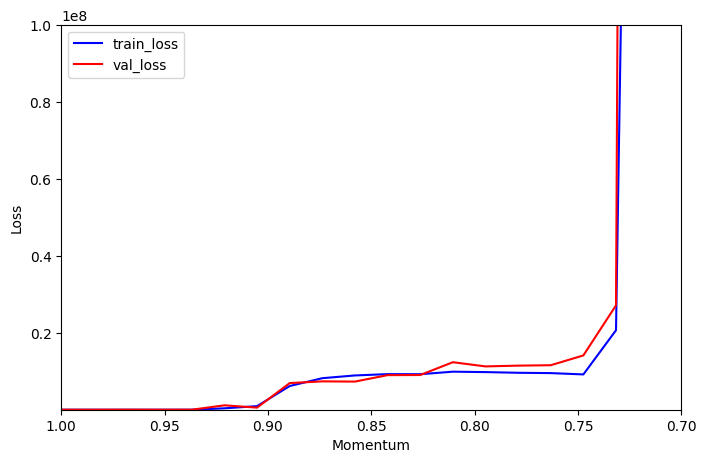

In [61]:
plt.figure(figsize=(8, 5))
mom_rates = np.linspace(1.0, 0.7, 20)

plt.plot(mom_rates, history4.history['loss'], 'b-', label='train_loss')
plt.plot(mom_rates, history4.history['val_loss'], 'r-', label='val_loss')

plt.xlabel('Momentum')
plt.ylabel('Loss')
plt.xlim([1.0, 0.7])
plt.ylim([1, 100000000])
plt.legend()
plt.show()